In [1]:
import aiida

# must execute it in the first place
aiida.load_profile()


In [2]:
from aiida.orm import Code
from aiida.orm import Str, Int, Dict, List, Float
from aiida.engine import calcfunction, WorkChain, ToContext, append_
from aiida.plugins import DataFactory, WorkflowFactory
from itertools import cycle
import os

from aiida.engine import calcfunction, workfunction, submit, run, run_get_node
from aiida.engine import run_get_node
from aiida.orm import load_code, load_node
from ase import io
from tools import wait_for_node_finished

from aiida_alamode.io import load_atoms_bare
from aiida_alamode.io import load_atoms

# load types
StructureData = DataFactory('structure')
FolderData = DataFactory('folder')
SinglefileData = DataFactory('singlefile')
ArrayData = DataFactory('array')
List = DataFactory('list')
TrajectoryData = DataFactory('array.trajectory')


In [3]:
# codeの定義を行う。
from tools.aiida_support import get_or_create_local_computer, get_or_create_code
from os.path import expanduser
import os

home = expanduser("~")
work_directory = os.path.join(home, 'aiida')
computer_local = get_or_create_local_computer(work_directory, 'localhost')
print(computer_local)
code = get_or_create_code('alamode.displace_pf',
                          computer_local,
                          '/home/max/Documents/aiida-alamode/aiida_alamode/alamode/displace.py')
code_displace_pf = code
code = get_or_create_code('alamode.displace_random',
                          computer_local,
                          '/home/max/Documents/aiida-alamode/aiida_alamode/alamode/displace.py')
code_displace_random = code
code = get_or_create_code('alamode.lammps',
                          computer_local,
                          '/usr/bin/lammps')
code_lammps_name = Str('alamode.lammps@localhost')

code = get_or_create_code('alamode.extract',
                          computer_local,
                          '/home/max/Documents/aiida-alamode/aiida_alamode/alamode/extract.py')
code_extract = code
code_extract_name = Str('alamode.extract@localhost')


code_displace_random, code_displace_pf, code_lammps_name


localhost (localhost), pk: 2


(<Code: Remote code 'alamode.displace_random' on localhost, pk: 2385, uuid: c893e5e1-c9ed-4d33-91eb-b4c8c2848412>,
 <Code: Remote code 'alamode.displace_pf' on localhost, pk: 2384, uuid: 1ded5557-bd21-4ebc-b2b5-f524c5ab4e25>,
 <Str: uuid: 11016b96-bbfc-497b-8d27-c033513beebc (unstored) value: alamode.lammps@localhost>)

In [4]:
import json
with open("setting.json") as f:
    _dic = json.load(f)
print(_dic)
CWD = _dic["CWD"]
_path = os.path.abspath(CWD)
os.makedirs(_path, exist_ok=True)
_path


{'CWD': 'run35'}


'/home/max/Documents/aiida-alamode_public/example/run35'

In [5]:
g_graph = True


In [6]:

from os.path import expanduser
from tools import NodeBank


# 再実行時に作成したノードを用いるためにnodebankを使う。
g_force = False
nodebank = NodeBank(_path, force=g_force)


In [7]:
g_cwd = nodebank.load("cwd")  # ファイル保存directory
g_superstructure = nodebank.load("superstructure")  # 使用する長周期構造StructureData
g_file_format = nodebank.load("structure_org_format")  # lammpsの位置フォーマット
g_prefix = nodebank.load('prefix')
g_prefix, g_file_format,  g_superstructure


(<Str: uuid: 43812d12-3c45-4981-8877-26f40299b550 (pk: 3587) value: harmonic>,
 <Str: uuid: e3b73297-2fa5-4218-a814-c1cb1ba89f47 (pk: 3560) value: lammps-data>,
 <StructureData: uuid: 1eb2842f-97b4-4aef-8620-145bf24e0619 (pk: 3581)>)

## for LAMMPS

In [8]:
key = "format"
g_format = nodebank.load_or_dump(key, Str("LAMMPS"))  # alamodeのファイルオプションの定義


debug, node uuid: 974b0887-fc03-4224-aee5-655d8839f901 (unstored) value: LAMMPS
debug, load None
debug, force dump


In [9]:
from aiida_lammps.tests.utils import (
    get_or_create_local_computer, get_or_create_code)
from aiida_lammps.tests.utils import lammps_version
computer_local = get_or_create_local_computer('work_directory', 'localhost')
code_lammps_force = get_or_create_code('lammps.force', computer_local, 'lammps')


In [10]:
code_lammps_force_name = Str(code_lammps_force.label+"@"+'localhost')
code_lammps_force_name


<Str: uuid: a6930400-3f98-4559-bc73-5613e421d039 (unstored) value: lammps.force-lammps-localhost@localhost>

In [11]:
code_lammps_force.get_from_string(code_lammps_force_name.value)


<Code: Remote code 'lammps.force-lammps-localhost' on localhost, pk: 2389, uuid: 74769bd2-a4ae-4667-8de0-ca33c93edf5b>

In [12]:
g_mag = nodebank.load_or_dump("mag", Float(0.01))


debug, node uuid: 11bfae43-030e-4e2b-9a1a-817888563d46 (unstored) value: 0.01
debug, load None
debug, force dump


In [13]:

displacement_patterns = nodebank.load(f'{g_prefix.value}_pattern')
displacement_patterns[0]


[[[0, [1.0, 0.0, 0.0], 'Cartesian']]]

# dispalce_pf
```
Description:

	displace.py -pf
	
	The pattern files are generated as f"{prefix}.{pattern_file_ext}", where pattern_file_ext is 'harmonic' or 'cubic.
	The displacement files are generated as f"{prefix}{counter}.POSCAR" and so on.
	
	defalt input filename: displace_Pf.in
	default output filename: displace_pf.out

Inputs:
                  code:  required  Code             The `Code` to use for this job.
                format:  required  Str              structure file format
                   mag:  required  Float            magnitude of displacement
               pattern:  required  List             displacement pattern
         structure_org:  required  StructureData    equilibrium structure
                   cwd:  optional  Str              directory where results are saved.
              metadata:  optional                   
                  mode:  optional  Str              displace must (must be 'pf'
                norder:  optional  Int              1 (harmonic) or 2 (cubic)
                prefix:  optional  Str              string added to the filename
Outputs:
  displaced_structures:  required  TrajectoryData   
         remote_folder:  required  RemoteData       Input files necessary to run the process will be stored in this folder node ...
               results:  required  Dict             
             retrieved:  required  FolderData       Files that are retrieved by the daemon will be stored in this node. By defa ...
          remote_stash:  optional  RemoteStashData  Contents of the `stash.source_list` option are stored in this remote folder ...

```
# displace_random
```
Description:

	displace.py --random
	
	The displacement files are generated as f"{prefix}{counter}.POSCAR" and so on.
	
	default input filename: displace_random.in
	default output filename: displace_random.out
	
	If 'cwd' is given. The retrieved files will be saved in the directory specified by 'cwd'.

Inputs:
                  code:  required  Code                                The `Code` to use for this job.
                format:  required  Str                                 structure file format
                   mag:  required  Float                               magnitude of displacement
              num_disp:  required  Int                                 number of set of displacement
         structure_org:  required  StructureData, SinglefileData, Str  equilibrium structure
                   cwd:  optional  Str                                 directory where results are saved.
              metadata:  optional                                      
                  mode:  optional  Str                                 'random' (fixed)
                norder:  optional  Int                                 1 (harmonic) or 2 (cubic)
                prefix:  optional  Str                                 string added to filenames.
Outputs:
       dispfile_folder:  required  FolderData                          
  displaced_structures:  required  TrajectoryData                      
         remote_folder:  required  RemoteData                          Input files necessary to run the process will be stored in this folder node ...
               results:  required  Dict                                
             retrieved:  required  FolderData                          Files that are retrieved by the daemon will be stored in this node. By defa ...
          remote_stash:  optional  RemoteStashData                     Contents of the `stash.source_list` option are stored in this remote folder ...

```

In [14]:
code_displace_pf


<Code: Remote code 'alamode.displace_pf' on localhost, pk: 2384, uuid: 1ded5557-bd21-4ebc-b2b5-f524c5ab4e25>

In [15]:
g_action = "pf"  # pf or random

pattern_filenames = List(list=[f'pattern.{g_prefix.value}'])

if g_action == "pf":

    #codename = "alamode.displace_pf@tutor"
    #code = Code.get_from_string(codename)
    code = code_displace_pf

    builder = code.get_builder()
    builder.format = g_format
    builder.cwd = Str(os.path.join(g_cwd.value, f"{g_prefix.value}_displace_pf"))
    # builder.prefix = g_prefix
    builder.structure_org = g_superstructure
    builder.mag = g_mag
    builder.pattern = displacement_patterns

    g_displacefuture = nodebank.load_code_or_wait_for_node(f"{g_prefix.value}_displace_pf", builder)


elif g_action == "random":

    g_num_disp = nodebank.load_or_dump(f"{g_prefix.value}_num_disp", Int(5))

    #codename = "alamode.displace_random@tutor"
    #code = Code.get_from_string(codename)
    code = code_displace_random

    builder = code.get_builder()
    builder.format = g_format
    builder.cwd = g_cwd
    builder.prefix = g_prefix
    builder.structure_org = g_superstructure
    builder.mag = g_mag
    builder.num_disp = g_num_disp

    g_displacefuture = nodebank.load_code_or_wait_for_node(f"{g_prefix.value}_displace_random", builder)

else:
    raise ValueError("unknown action")


None
uuid: 669af1f1-03c9-4942-9c6d-a29191ddba27 (pk: 3606) (aiida.calculations:alamode.displace_pf)
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
True True
0:00:12.603739


In [16]:
g_displacefuture.outputs.retrieved.list_object_names()


['_aiidasubmit.sh',
 '_scheduler-stderr.txt',
 '_scheduler-stdout.txt',
 'disp1.lammps',
 'displace_pf.out']

In [17]:
# 構造出力、例0番目
print(g_displacefuture.outputs.displaced_structures.get_stepids())
structure = g_displacefuture.outputs.displaced_structures.get_step_structure(0)
structure.get_ase().get_positions()


[0]


array([[0.01, 0.  , 0.  ],
       [4.05, 4.05, 1.35],
       [0.  , 2.7 , 2.7 ],
       [4.05, 1.35, 4.05],
       [2.7 , 0.  , 2.7 ],
       [1.35, 4.05, 4.05],
       [2.7 , 2.7 , 0.  ],
       [1.35, 1.35, 1.35],
       [0.  , 0.  , 5.4 ],
       [4.05, 4.05, 6.75],
       [0.  , 2.7 , 8.1 ],
       [4.05, 1.35, 9.45],
       [2.7 , 0.  , 8.1 ],
       [1.35, 4.05, 9.45],
       [2.7 , 2.7 , 5.4 ],
       [1.35, 1.35, 6.75],
       [0.  , 5.4 , 0.  ],
       [4.05, 9.45, 1.35],
       [0.  , 8.1 , 2.7 ],
       [4.05, 6.75, 4.05],
       [2.7 , 5.4 , 2.7 ],
       [1.35, 9.45, 4.05],
       [2.7 , 8.1 , 0.  ],
       [1.35, 6.75, 1.35],
       [0.  , 5.4 , 5.4 ],
       [4.05, 9.45, 6.75],
       [0.  , 8.1 , 8.1 ],
       [4.05, 6.75, 9.45],
       [2.7 , 5.4 , 8.1 ],
       [1.35, 9.45, 9.45],
       [2.7 , 8.1 , 5.4 ],
       [1.35, 6.75, 6.75],
       [5.4 , 0.  , 0.  ],
       [9.45, 4.05, 1.35],
       [5.4 , 2.7 , 2.7 ],
       [9.45, 1.35, 4.05],
       [8.1 , 0.  , 2.7 ],
 

In [18]:
# 次のsimulatorへのinput
g_displaced_structures = g_displacefuture.outputs.displaced_structures

# simulatorの実行

## load tersoff potential

In [19]:
import json
# with open("lammps_input/potentials/tersoff-GaN.json","r") as f:
with open("lammps_input/potentials/tersoff.json", "r") as f:
    potential_dict = json.load(f)
lammps_potential = DataFactory("lammps.potential")(
    type=potential_dict["pair_style"], data=potential_dict["potential_dict"]
)
lammps_potential


<EmpiricalPotential: uuid: 4fa99e14-5ca1-4dfa-9d5a-0b1bd2fcfd73 (unstored)>

## execution option

## run all the displacements

# "alamode.force_simulator_lammps
```
Description:

	parallen execution of lammps.force

Inputs:
  code_string:  required  Str                 label of your 'lammps.force' code
   parameters:  required  Dict                additional parameters to pass 'lammps.force'
    potential:  required  EmpiricalPotential  lammps potential
   structures:  required  TrajectoryData      dispalced structures
          cwd:  optional  Str                 directory where results are saved.
     metadata:  optional                      
      options:  optional  Dict                metadata.options
       prefix:  optional  Str                 string added to filenames
Outputs:
      displacement_and_forces:  required  Dict                displacement and forces
       forces:  required  List                resulting forces
      results:  required  List          
```

In [20]:
alldisp_lammps_WorkChain = WorkflowFactory("alamode.force_simulator_lammps")


In [21]:
lammps_parameters = DataFactory('dict')(dict={
    'lammps_version': lammps_version(),
    'output_variables': ["temp", "etotal", "pe", "ke"],
    'thermo_keywords': []
})
meta_options = {
    "resources": {
        "num_machines": 1,
        "num_mpiprocs_per_machine": 1}
}


In [22]:
inputs = {"structures": g_displaced_structures,
          "parameters": lammps_parameters,
          "code_string":  code_lammps_force_name,
          "cwd": Str(os.path.join(g_cwd.value, f"{g_prefix.value}_alldisp")),
          "prefix": g_prefix,
          'potential': lammps_potential}


In [23]:
# 実行もしくは過去の実行のID
lammps_all = nodebank.load_workchain_or_wait_for_node(f"{g_prefix.value}_all_lammps", 
                                                      alldisp_lammps_WorkChain, inputs, 
                                                      sec=10)


wait another 10 sec.
True True
True
0:00:10.251647


In [24]:
lammps_all.attributes


{'sealed': True,
 'version': {'core': '1.6.9', 'plugin': '0.8'},
 'exit_status': 0,
 'process_label': 'ForcesLammpsWorkChain',
 'process_state': 'finished',
 'stepper_state_info': '1:inspect_workchains'}

In [25]:
g_target_dict = lammps_all.outputs.displacement_and_forces
g_target_dict.get_dict()


{'LAMMPS': ['ITEM: TIMESTEP\n0\nITEM: NUMBER OF ATOMS\n64\nITEM: BOX BOUNDS xy xz yz pp pp pp\n0.0000000000000000e+00 1.0800000000000001e+01 0.0000000000000000e+00\n0.0000000000000000e+00 1.0800000000000001e+01 0.0000000000000000e+00\n0.0000000000000000e+00 1.0800000000000001e+01 0.0000000000000000e+00\nITEM: ATOMS element xu yu zu fx fy fz\n  Si     0.0100000000     0.0000000000     0.0000000000    -0.1589257934    -0.0000000000    -0.0000000000\n  Si     4.0500000000     4.0500000000     1.3500000000     0.0000000000     0.0000000000    -0.0000000000\n  Si     0.0000000000     2.7000000000     2.7000000000    -0.0023858035    -0.0002835937    -0.0002835937\n  Si     4.0500000000     1.3500000000     4.0500000000     0.0000000000    -0.0000000000     0.0000000000\n  Si     2.7000000000     0.0000000000     2.7000000000     0.0001842351     0.0002923989    -0.0007952245\n  Si     1.3500000000     4.0500000000     4.0500000000    -0.0000000000     0.0000000000     0.0000000000\n  Si    

In [26]:
len(g_target_dict.attributes["LAMMPS"])


1

3616
Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 3616.dot.pdf


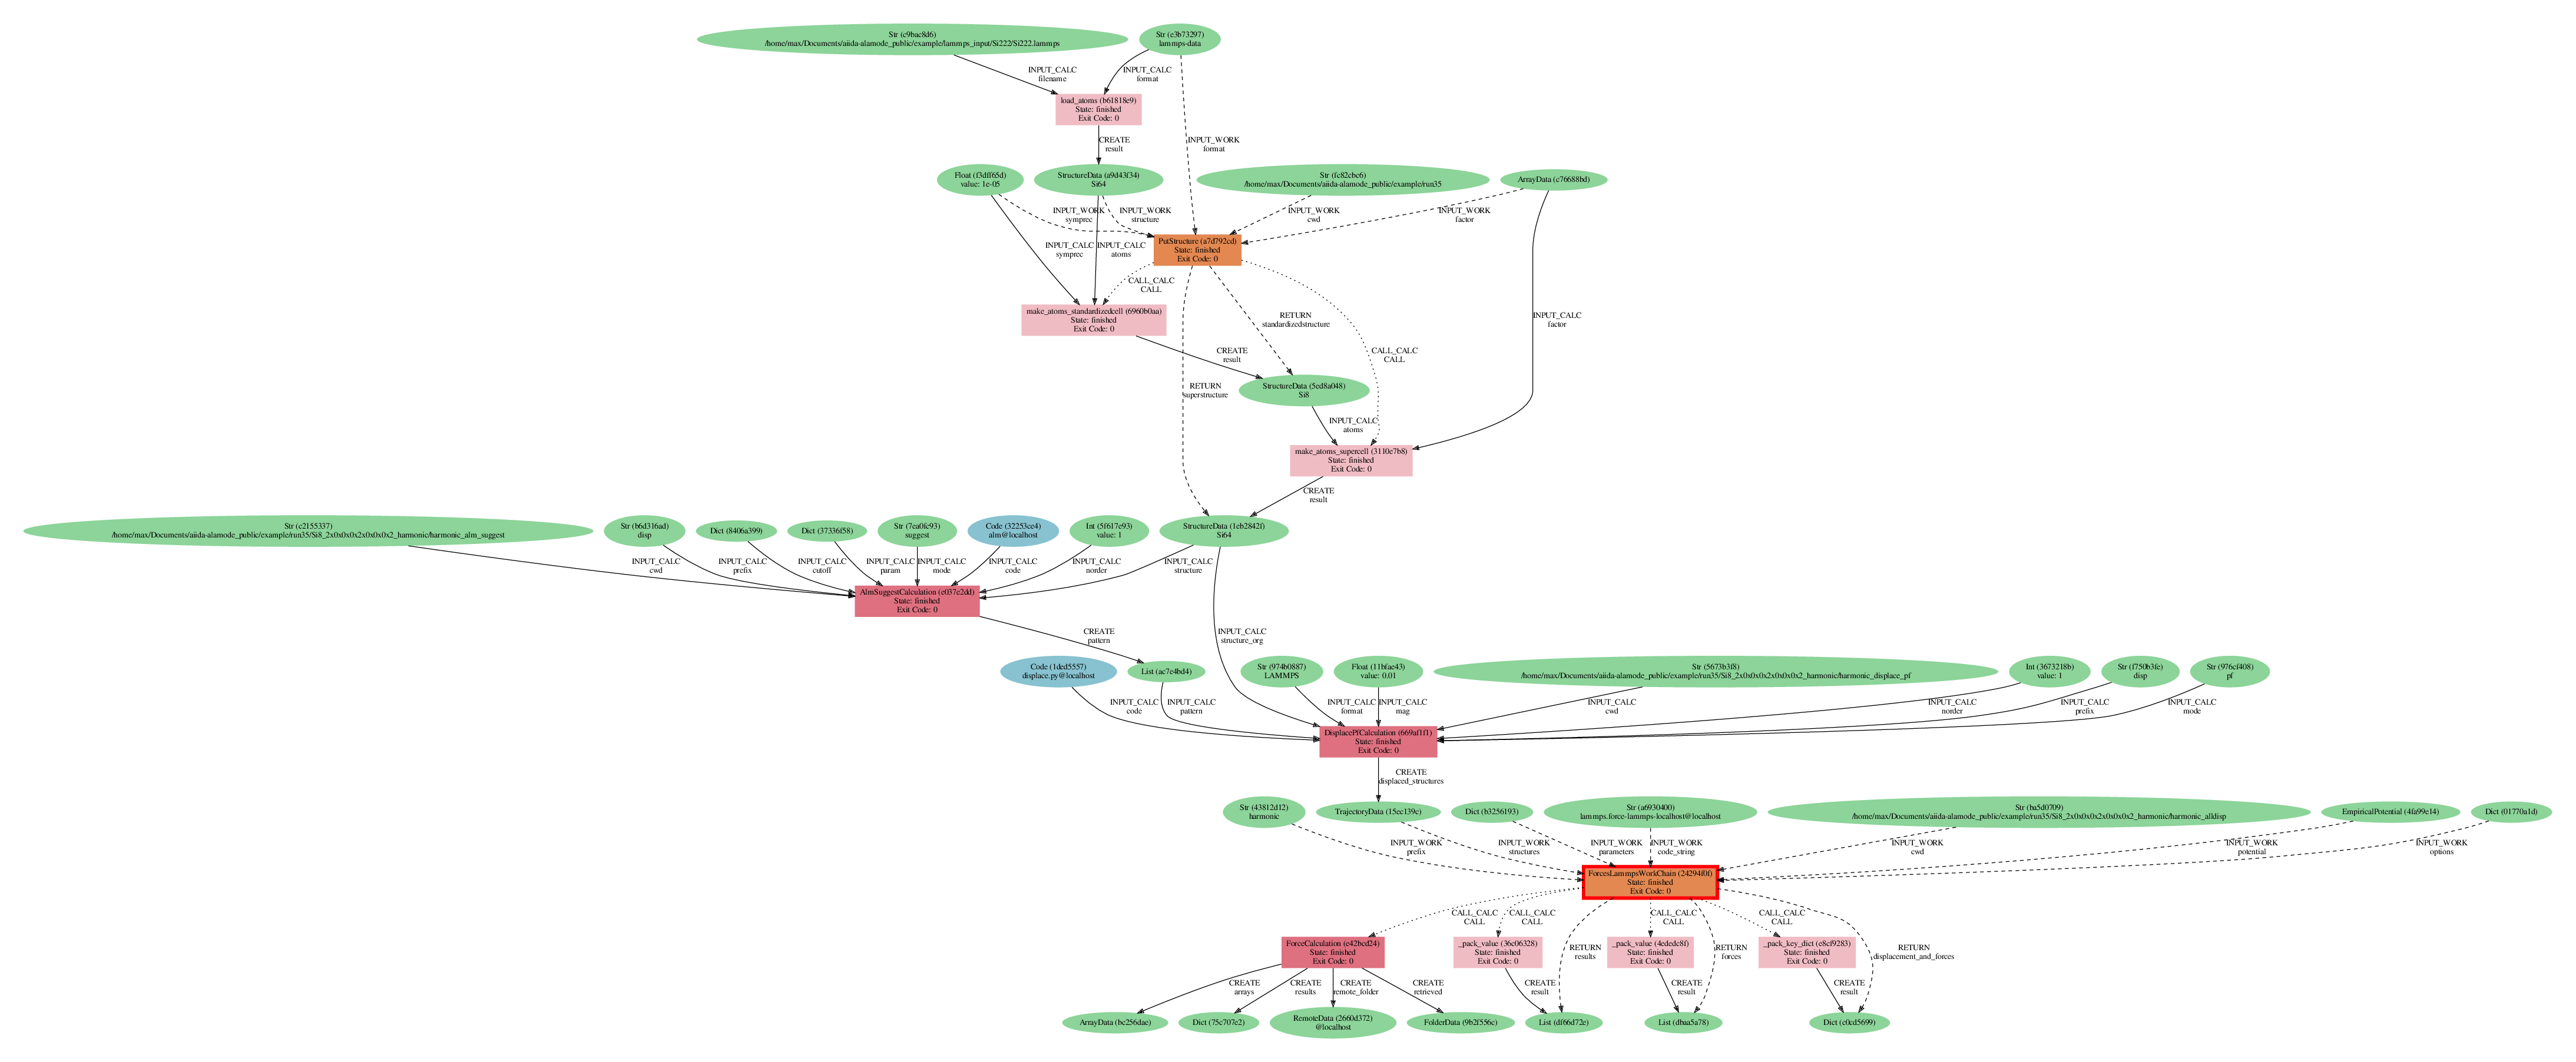

In [27]:
if g_graph:
    pk = lammps_all.pk
    print(pk)
    !verdi node graph generate $pk
    from wand.image import Image as WImage
    filename = f"{pk}.dot.pdf"
    img = WImage(filename=filename)
    display(img)

# another routine to make dfset

In [28]:
import numpy as np


"""unit conversion should be automatically done in ase.io."""

class UnitConversion:
    """
    Unit conversion.

    can't OpenMX set output units?
    """
    _BOHR_TO_ANGSTROM = 0.5291772108
    _RYDBERG_TO_EV = 13.60569253

    def __init__(self, format: str):
        if format in ["LAMMPS", "VASP"]:
            self._set_unit_conversion_factor_ang_eV()
        elif format in ["QE"]:
            self._set_unit_conversion_factor_bohr_rydberg()
        elif format in ["xTAPP"]:
            self._set_unit_conversion_factor_bohr_hartree()
        elif format in ["OpenMX"]:
            self._set_unit_conversion_factor_ang_hartree()

    def _set_unit_conversion_factor_ang_eV(self, str_unit='rydberg'):
        if str_unit == "ev":
            self.disp_conversion_factor = 1.0
            self.energy_conversion_factor = 1.0

        elif str_unit == "rydberg":
            self.disp_conversion_factor = 1.0 / self._BOHR_TO_ANGSTROM
            self.energy_conversion_factor = 1.0 / self._RYDBERG_TO_EV

        elif str_unit == "hartree":
            self.disp_conversion_factor = 1.0 / self._BOHR_TO_ANGSTROM
            self.energy_conversion_factor = 0.5 / self._RYDBERG_TO_EV

        else:
            raise RuntimeError("This cannot happen")

        self.force_conversion_factor \
            = self.energy_conversion_factor / self.disp_conversion_factor

    def _set_unit_conversion_factor_bohr_rydberg(self, str_unit='rydberg'):

        if str_unit == "ev":
            self._disp_conversion_factor = self._BOHR_TO_ANGSTROM
            self._energy_conversion_factor = self._RYDBERG_TO_EV

        elif str_unit == "rydberg":
            self._disp_conversion_factor = 1.0
            self._energy_conversion_factor = 1.0

        elif str_unit == "hartree":
            self._disp_conversion_factor = 1.0
            self._energy_conversion_factor = 0.5

        else:
            raise RuntimeError("This cannot happen.")

        self._force_conversion_factor = self._energy_conversion_factor / self._disp_conversion_factor

    def _set_unit_conversion_factor_bohr_hartree(self, str_unit):

        if str_unit == "ev":
            self._disp_conversion_factor = self._BOHR_TO_ANGSTROM
            self._energy_conversion_factor = 2.0 * self._RYDBERG_TO_EV

        elif str_unit == "rydberg":
            self._disp_conversion_factor = 1.0
            self._energy_conversion_factor = 2.0

        elif str_unit == "hartree":
            self._disp_conversion_factor = 1.0
            self._energy_conversion_factor = 1.0

        else:
            raise RuntimeError("This cannot happen.")

        self._force_conversion_factor = self._energy_conversion_factor / self._disp_conversion_factor

    def _set_unit_conversion_factor_ang_hartree(self, str_unit):

        if str_unit == "ev":
            disp_conv_factor = 1.0
            energy_conv_factor = 2.0 * self._RYDBERG_TO_EV
            force_conv_factor = energy_conv_factor / self._BOHR_TO_ANGSTROM

        elif str_unit == "rydberg":
            disp_conv_factor = 1.0 / self._BOHR_TO_ANGSTROM
            energy_conv_factor = 2.0
            force_conv_factor = 2.0

        elif str_unit == "hartree":
            disp_conv_factor = 1.0 / self._BOHR_TO_ANGSTROM
            energy_conv_factor = 1.0
            force_conv_factor = 1.0

        else:
            raise RuntimeError("This cannot happen")

        self._disp_conversion_factor = disp_conv_factor
        self._force_conversion_factor = force_conv_factor
        self._energy_conversion_factor = energy_conv_factor


@calcfunction
def make_dfset(displaced_structures, structure_org: StructureData, format: Str):
    """
    calculate displacement = displaced_structures-structure_org
    and force in 'unit'.

    Args:
        displaced_structures (TrajectoryData): displaced structures
        structure_org (StructureData): equilibrium structure
        format (Str): simulator format

    Returns:
        np.array:  DFSET = dstacked (displacement, force) in the 'unit.'
    """
    if format == "LAMMPS":
        # position in Ang.
        # force in eV/Ang.
        unit = "rydberg"
        structures = g_displacefuture.outputs.displaced_structures.get_array("positions")
        displacement = structures - structure_org.get_ase().get_positions()  # in Ang.
        unit_conversion = UnitConversion(format)
        displacement *= unit_conversion.disp_conversion_factor  # in Au.
        forces = np.array(lammps_all.outputs.forces.get_list())  # in eV/Ang
        forces *= unit_conversion.force_conversion_factor  # in Au.
        dfset = ArrayData()
        dfset.set_array('dfset', np.dstack((displacement, forces)))
    elif format == "VASP":
        # position in Ang.
        # force in eV/Ang.
        raise ValueError('VASP not implemented')
    elif format == "QE":
        # position in ?
        # force in ?
        raise ValueError('QE not implemented')

    return dfset


In [29]:
dfset = make_dfset(g_displacefuture.outputs.displaced_structures, g_superstructure, g_format)
dfset

<ArrayData: uuid: fc0fcc25-6af0-4302-b96e-2c0819dbdc74 (pk: 3630)>

In [30]:
dfset.get_array("dfset")

array([[[ 1.88972612e-02,  0.00000000e+00,  0.00000000e+00,
         -6.18122950e-03,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -9.27929864e-05, -1.10300393e-05, -1.10300393e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          7.16560485e-06,  1.13725071e-05, -3.09293101e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          7.16560485e-06, -3.09293101e-05,  1.13725071e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.63307440e-03,  1.40227914e-03,  1.40227914e-03],
        [ 0.00000000e+00,  0.000

# make positions and forces

# extract

# alamode.extract
```
Description:

	extract.py

Inputs:
           code:  required  Code             The `Code` to use for this job.
        dispset:  required  Dict             displacement and focrces
         format:  required  Str              structure file format
         prefix:  required  Str              string added to filenames
  structure_org:  required  StructureData    equilibrium structure
            cwd:  optional  Str              directory where results are saved.
       metadata:  optional                   
Outputs:
          dfset:  required  List             
  remote_folder:  required  RemoteData       Input files necessary to run the process will be stored in this folder node ...
      retrieved:  required  FolderData       Files that are retrieved by the daemon will be stored in this node. By defa ...
   remote_stash:  optional  RemoteStashData  Contents of the `stash.source_list` option are stored in this remote folder ...

```

In [31]:
code_extract = Code.get_from_string(code_extract_name.value)



In [32]:
builder = code_extract.get_builder()
builder.format = g_format
builder.structure_org = g_superstructure
builder.cwd = Str(os.path.join(g_cwd.value, f"{g_prefix.value}_extract"))
builder.prefix = g_prefix
builder.displacement_and_forces = g_target_dict


In [33]:
extract = submit(builder)
print(extract)
wait_for_node_finished(extract)
if not extract.is_finished_ok:
    raise


uuid: b0487c08-0321-4855-930f-88bd8da6b17d (pk: 3634) (aiida.calculations:alamode.extract)
wait another 2 sec.
wait another 2 sec.
True True


In [34]:
nodebank.dump(f"{g_prefix.value}_extract", extract)


<CalcJobNode: uuid: b0487c08-0321-4855-930f-88bd8da6b17d (pk: 3634) (aiida.calculations:alamode.extract)>

3634
Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 3634.dot.pdf


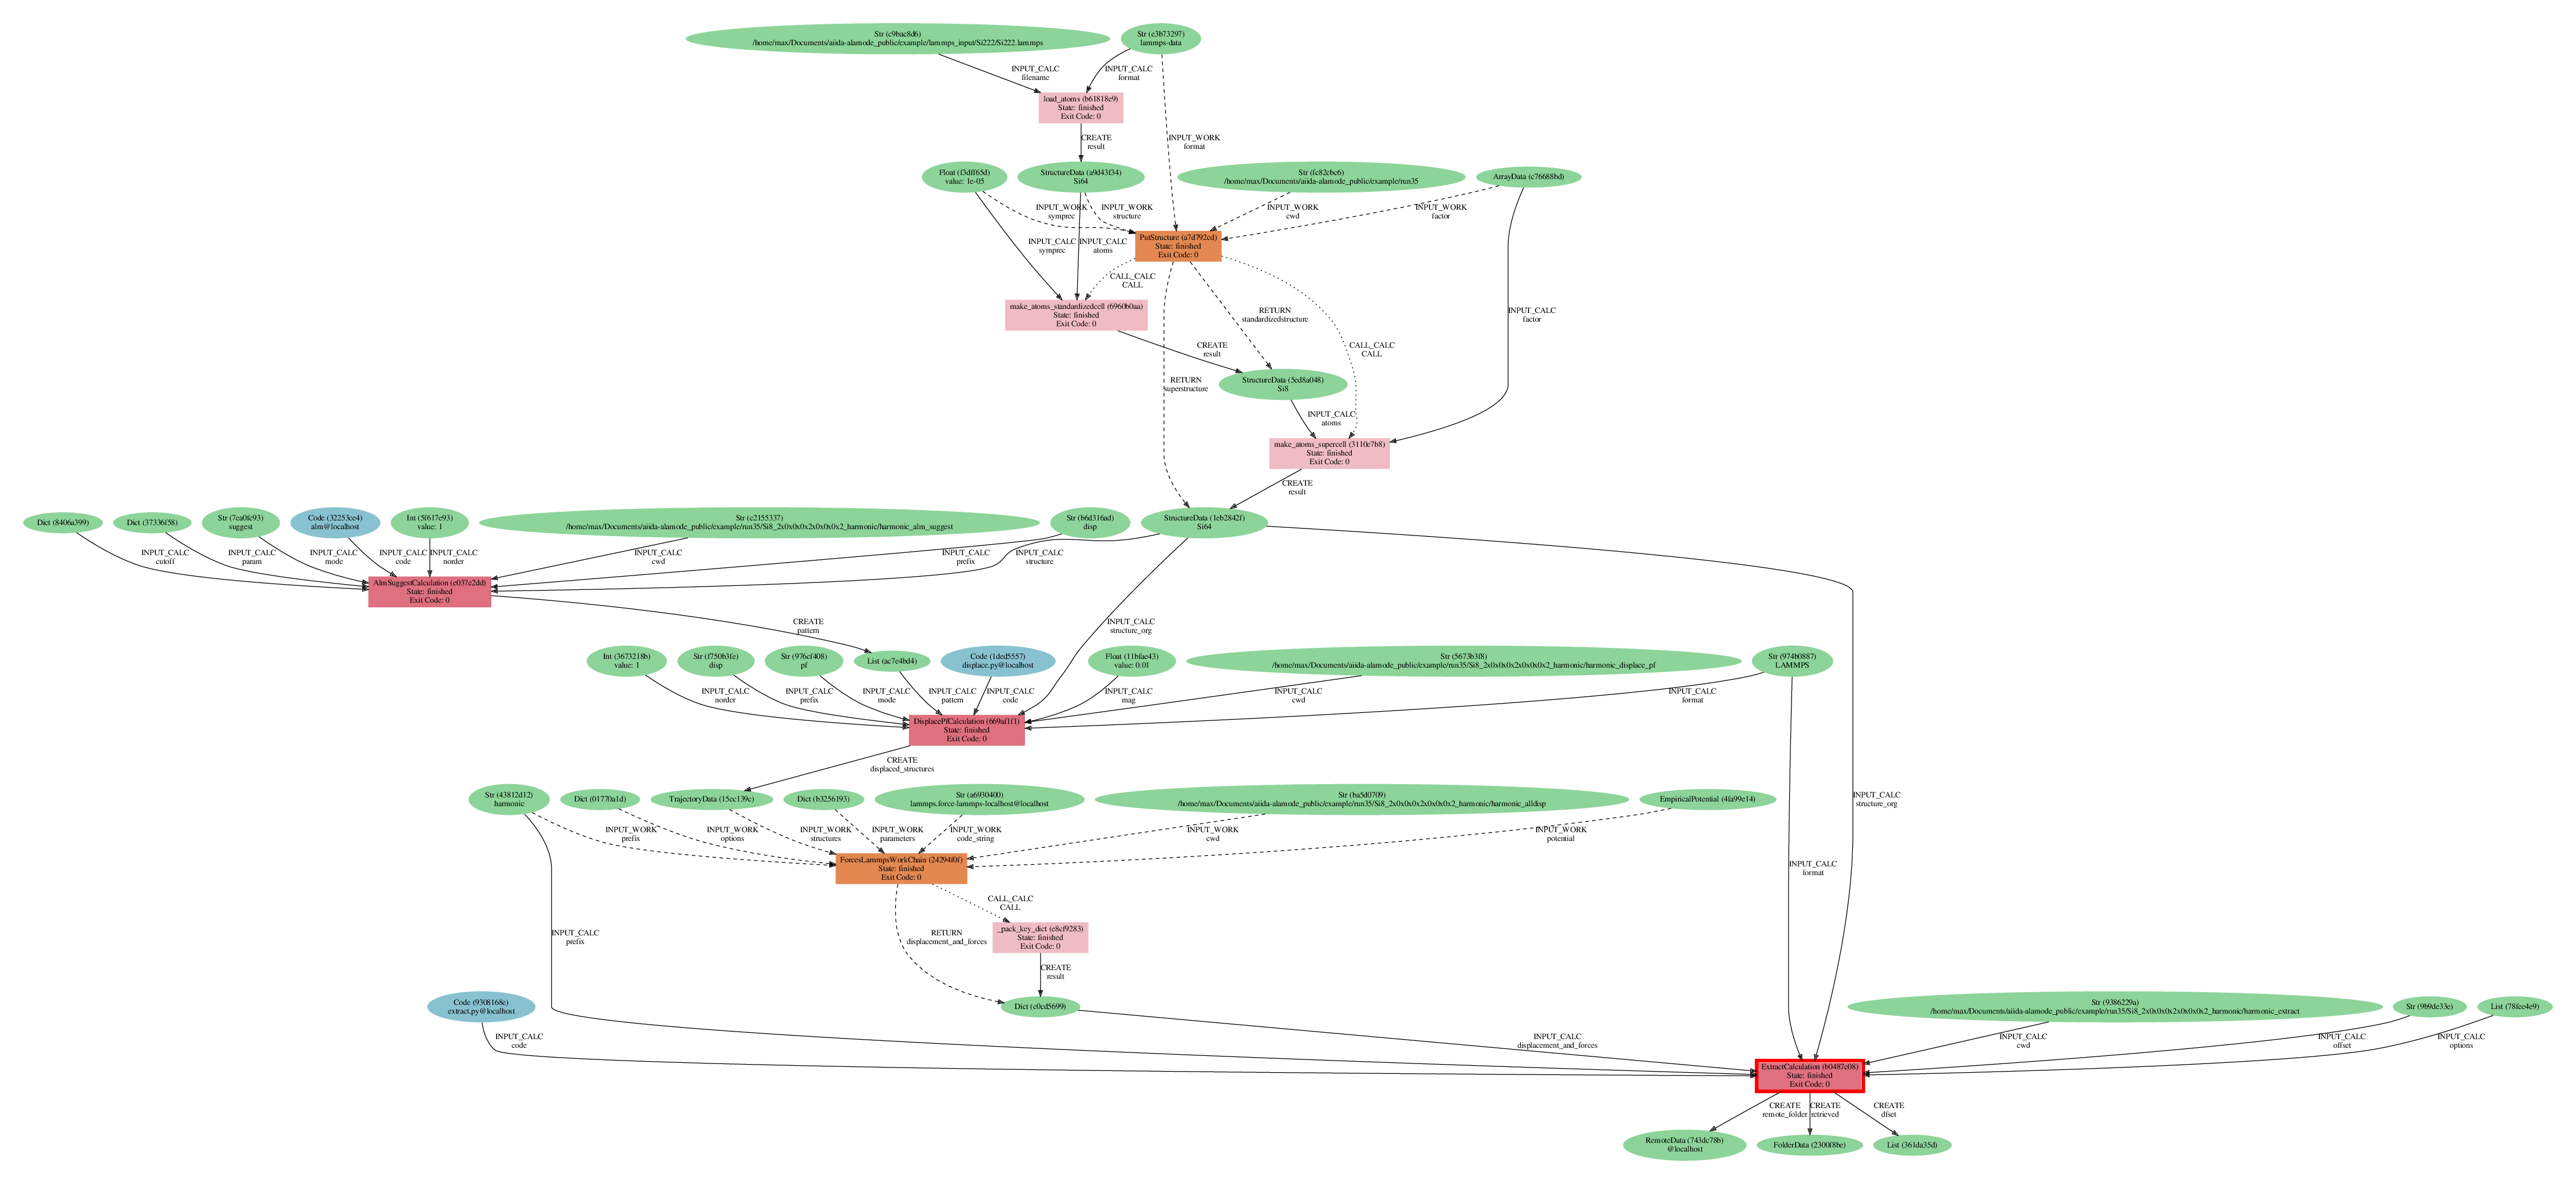

In [35]:
if g_graph:
    pk = extract.pk
    print(pk)
    !verdi node graph generate $pk
    from wand.image import Image as WImage
    filename = f"{pk}.dot.pdf"
    img = WImage(filename=filename)
    display(img)